# Regression Trees

This notebook implements a regression tree algorithm for classification to showcase the utility and functionality **of the written decision tree algorithm**. For a description of the algorithm **and the background**, see **this README**.

The notebook is separated into several sections, each containing **separate aspects of the data analysis/data preprocessing process**. They are **as follows**

### Library Imports
This section imports the libraries **and modules** required to run the decision tree algorithm. The **following dependencies are required**

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from rice_ml.preprocess import *
from rice_ml.supervised_learning.decisiontrees import *
from rice_ml.postprocess.regressionpost import *

### Data Loading & Cleaning
The data used in this notebook comes from Palmer Penguins, a common toy dataset for evaluating classification algorithms due to its **clear-cut features/simplicity/not too large/other benefits**. It has been chosen **because it is simple for classification** and requires several preprocessing steps, including **handling missing values**, which **showcase the preprocessing modules/package**. This dataset contains the following feature data for 344 penguins:
- Species: **fill this in, three species - 'Adelie' 'Chinstrap' 'Gentoo'**
- Island: **fill this in - 'Biscoe' 'Dream' 'Torgersen'**
- Bill Length (mm): continuous values, measuring bill length in millimeters
- Bill Depth (mm): continuous values, measuring bill depth in millimeters
- Flipper Length (mm): continuous values, measuring flipper length in millimeters
- Body Mass (g): continuous values, measuring body mass in grams
- Sex: **binary male/female**

**we drop some features - this is different from classification!** 
**This section covers the actual loading of the data; the data is loaded using `sns.load_dataset("penguins")`. Explanation here!! why those features?? encode using pandas uniques. Then cleaned using preprocessing - dropped missing values, identified outliers with z-scoring and dropped, dropped duplicates, z-scored the feature data for standardization**

In [33]:
# Loading the basic dataset and selecting features
penguins_df = sns.load_dataset("penguins")
penguin_features = penguins_df[[
    "bill_length_mm", 
    "bill_depth_mm", 
    "flipper_length_mm", 
    "body_mass_g"
]]
display(penguin_features)

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,39.1,18.7,181.0,3750.0
1,39.5,17.4,186.0,3800.0
2,40.3,18.0,195.0,3250.0
3,NaN,NaN,NaN,NaN
4,36.7,19.3,193.0,3450.0
...,...,...,...,...
339,NaN,NaN,NaN,NaN
340,46.8,14.3,215.0,4850.0
341,50.4,15.7,222.0,5750.0
342,45.2,14.8,212.0,5200.0


The dataset contains **some missing values (e.g., row 4)** and **may contain outliers or duplicates**. As in classification, to **put the data in a usable format**, we apply a series of preprocessing **algorithms**, including dropping any rows with missing values, outliers, or that are identified to be duplicates of another.

In [34]:
# Cleaning the dataset (dropping rows with missing values, duplicates, or containing outliers)
penguin_features_cleaned_missing = missing_data(penguin_features, 'drop')
penguin_features_cleaned_outliers = outlier_identify(penguin_features_cleaned_missing, 'zscore', drop = True)
penguin_features_cleaned = duplicate_identify(penguin_features_cleaned_outliers, True)
print(f"Cleaned data (first five rows): \n {penguin_features_cleaned[0:5, :]}")

Cleaned data (first five rows): 
 [[  39.1   18.7  181.  3750. ]
 [  39.5   17.4  186.  3800. ]
 [  40.3   18.   195.  3250. ]
 [  36.7   19.3  193.  3450. ]
 [  39.3   20.6  190.  3650. ]]


Two rows have been removed during cleaning, and the dataset no longer contains NaN values. For use in regression trees and **for ease of visualization**, the dataset must be split into the target feature and the remaining **features**. **We are interested in seeing if we can predict body mass from bill length, bill depth, and flipper length**

In [35]:
# Creating two arrays
body_mass = penguin_features_cleaned[:, 3]
penguin_feature_data = penguin_features_cleaned[:, [0, 1, 2]]
print(f"Array for body_mass (first five entries): \n {body_mass[0:5]} \n \n \
Array for penguin feature data (first five rows): \n {penguin_feature_data[0:5]}")

Array for body_mass (first five entries): 
 [3750. 3800. 3250. 3450. 3650.] 
 
 Array for penguin feature data (first five rows): 
 [[ 39.1  18.7 181. ]
 [ 39.5  17.4 186. ]
 [ 40.3  18.  195. ]
 [ 36.7  19.3 193. ]
 [ 39.3  20.6 190. ]]


### Data Visualization
**TODO!!**

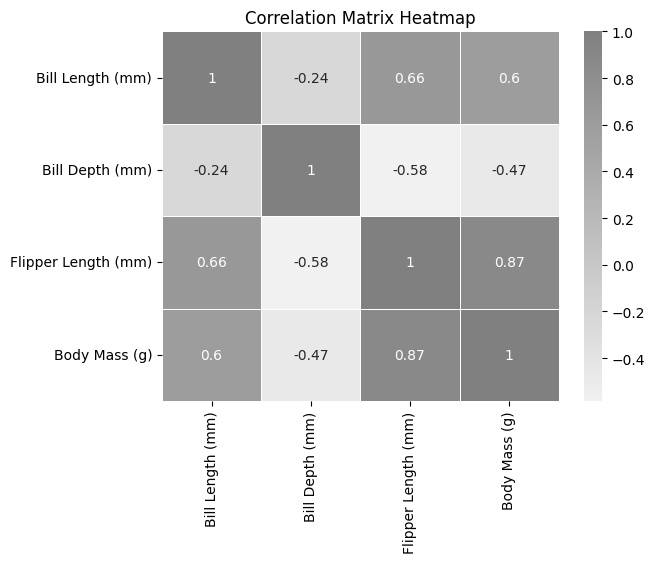

In [36]:
# Creating and plotting a correlation matrix with a heatmap
correlation_matrix = (pd.DataFrame(penguin_features_cleaned, columns = ['Bill Length (mm)', 'Bill Depth (mm)', 'Flipper Length (mm)', 'Body Mass (g)'])).corr()
sns.heatmap(correlation_matrix, annot = True, cmap=sns.light_palette('gray', as_cmap=True), linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

To predict body mass, we select flipper length and bill length as the features of interest, given that these have the greatest correlation (0.87 and 0.6, respectively) with the target variable. The relationship between these features can be visualized using a two-dimensional plot and color mappings that correspond to a range of body mass values.

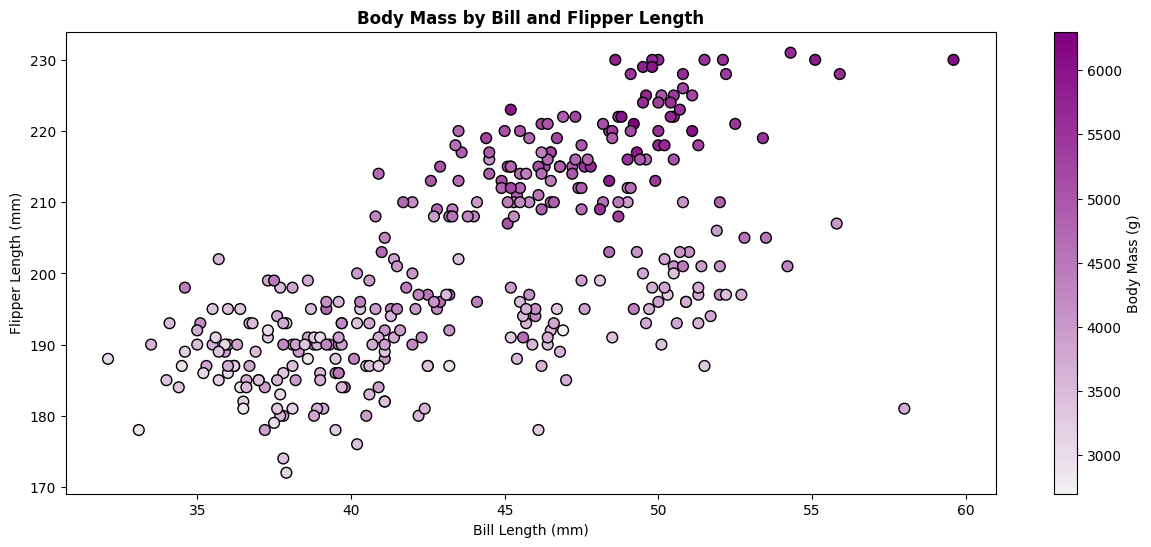

In [37]:
# Plotting bill length and flipper length, color-coded by body mass
plt.figure(figsize = (15, 6))
plt.scatter(penguin_feature_data[:, 0], penguin_feature_data[:, 2], c = body_mass, cmap = sns.light_palette('purple', as_cmap=True), s = 60, edgecolor = "k")
cbar = plt.colorbar()
cbar.set_label("Body Mass (g)")
plt.xlabel("Bill Length (mm)")
plt.ylabel("Flipper Length (mm)")
plt.title("Body Mass by Bill and Flipper Length", fontweight = 'bold')
plt.show()

These variables are positively correlated, as indicated in the correlation matrix. This relationship is apparent on the above plot; as bill length and flipper length increase, body mass increases as well, with slightly more influence of the flipper length value than the bill length.

### Regression Tree Implementation (2 Features)

This section **implements a basic regression tree algorithm for the two identified features to attempt to classify species**. **elaborate!!** 

**To avoid skewing results with different feature values**, we standardize the feature data **by calculating zscores** using the `z_score_standardize` **module** from the preprocessing package. This ensures that **no feature dominates/overrides the other ones** by **making them all the same scale**. The z-score equation used is **this!!**

In [38]:
# Standardizing the features
penguin_feature_data_normal = z_score_standardize(penguin_feature_data[:, [0, 2]])
print(f"Standardized feature data (first five rows): \n {penguin_feature_data_normal[0:5, :]}")

Standardized feature data (first five rows): 
 [[-0.88449874 -1.41834665]
 [-0.81112573 -1.06225022]
 [-0.66437972 -0.42127665]
 [-1.32473679 -0.56371522]
 [-0.84781224 -0.77737308]]


Once the data has been scaled, it is split into testing and training arrays. This ensures that the model is not trained and tested on the same set of data, allowing for unbiased evaluation of model performance and preventing overfitting. **stratification/0.3 test_array size**. There are 342 samples in **the cleaned dataset**, so the training array should have around 239/240 samples and the testing should have around 102/103.

In [39]:
# Splitting the data into training and testing arrays
train_array, test_array, train_targets, test_targets = train_test(penguin_feature_data_normal, body_mass)

# Verifying sizes of each array
print(f"Shape of training array: {train_array.shape}")
print(f"Shape of training targets: {train_targets.shape}")
print(f"Shape of testing array: {test_array.shape}")
print(f"Shape of testing targets: {test_targets.shape}")

Shape of training array: (239, 2)
Shape of training targets: (239,)
Shape of testing array: (103, 2)
Shape of testing targets: (103,)


We then **initialize a regression tree model using the supervised learning regression tree class. elaborate!!**

In [40]:
# Fitting the model
tree = regression_tree()
tree.fit(train_array, train_targets)

# Predicting body mass based on testing data
prediction = tree.predict(test_array)

**TODO: fill in w/ types of metrics!!**

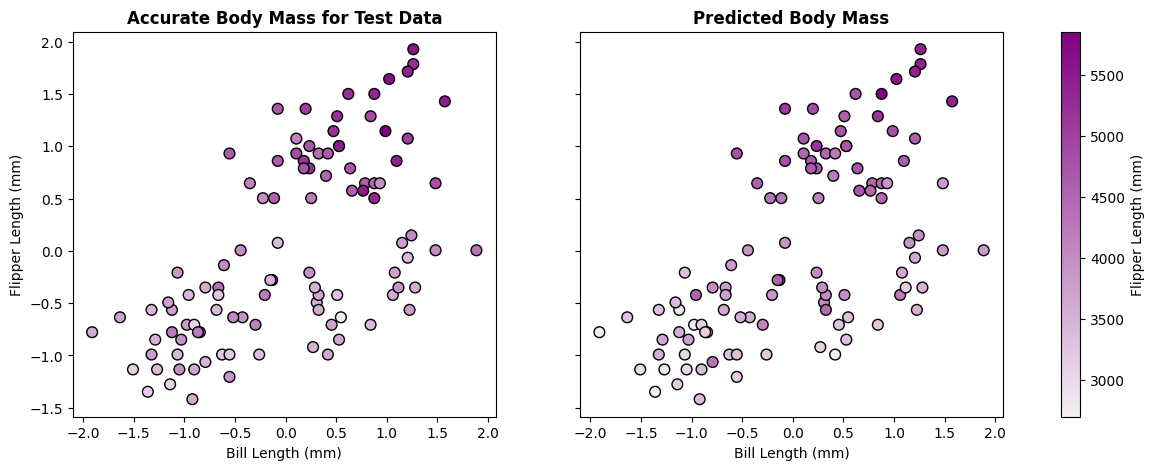

In [41]:
# Plotting bill length and flipper length for actual and predicted data, color-coded by body mass

fig, ax = plt.subplots(1, 2, figsize = (15, 5), sharey = True)
plot_1 = ax[0].scatter(test_array[:, 0], test_array[:, 1], c = test_targets, cmap = sns.light_palette('purple', as_cmap=True), s = 60, edgecolor = "k")
ax[0].set_xlabel("Bill Length (mm)")
ax[0].set_ylabel("Flipper Length (mm)")
ax[0].set_title("Accurate Body Mass for Test Data", fontweight = 'bold')

plot_2 = ax[1].scatter(test_array[:, 0], test_array[:, 1], c = prediction, cmap = sns.light_palette('purple', as_cmap=True), s = 60, edgecolor = "k")
ax[1].set_xlabel("Bill Length (mm)")
ax[1].set_title("Predicted Body Mass", fontweight = 'bold')

cbar = fig.colorbar(plot_1, ax = ax, location = 'right')
cbar.set_label("Flipper Length (mm)")
plt.show()

The regression tree itself can be visualized to determine the values of features that guide splits, and the splits can be plotted to visualize the boundaries.

In [42]:
# Printing the regression tree
tree.print_tree()

Feature 1 <= 0.682622275221658
	Feature 1 <= -0.5281055796101676
		Feature 0 <= -0.9578717502865859
			Feature 0 <= -1.9025492315452026
				Feature 0 <= -2.0768101261463063
					Predict: 3050.0
					Predict: 2900.0
				Feature 0 <= -0.9853866283814969
					Feature 1 <= -0.9198116502910524
						Feature 0 <= -1.352251669646979
							Feature 0 <= -1.3981097998051646
								Feature 0 <= -1.5907139464695428
									Feature 0 <= -1.737459962975736
										Feature 0 <= -1.783318093133921
											Predict: 3400.0
											Predict: 3325.0
										Feature 0 <= -1.664086954722639
											Predict: 2900.0
											Predict: 3050.0
									Feature 0 <= -1.5173409382164467
										Predict: 3800.0
										Feature 1 <= -1.0266405786585664
											Predict: 3100.0
											Feature 0 <= -1.4347963039317126
												Predict: 3700.0
												Predict: 3333.3333333333335
								Predict: 2850.0
							Feature 0 <= -1.205505653140786
								Feature 0 <= -1.2513637832989715
				

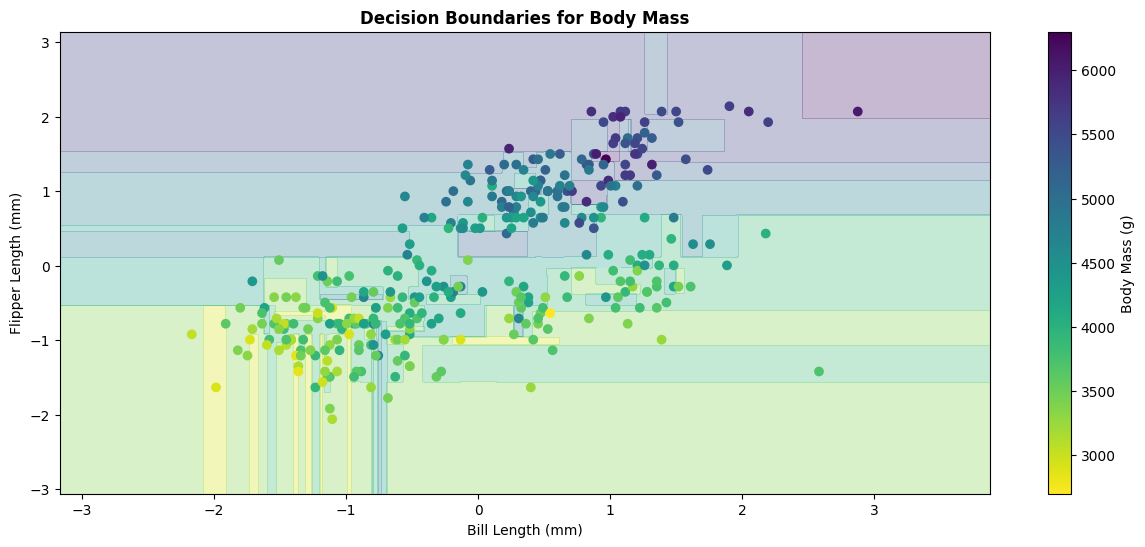

In [43]:
# Creating the meshgrid
x_min, x_max = penguin_feature_data_normal[:, 0].min() - 1, penguin_feature_data_normal[:, 0].max() + 1
y_min, y_max = penguin_feature_data_normal[:, 1].min() - 1, penguin_feature_data_normal[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                     np.linspace(y_min, y_max, 500))
grid_points = np.c_[xx.ravel(), yy.ravel()]
meshgrid_prediction = tree.predict(grid_points)
meshgrid_prediction = np.array(meshgrid_prediction, dtype = int).reshape(xx.shape)

# Plotting the decision boundaries
plt.figure(figsize=(15, 6))
cmap = ListedColormap(['pink', 'gray', '#CBC3E3'])
plt.contourf(xx, yy, meshgrid_prediction, alpha = 0.3, cmap = 'viridis_r')
colors = {0: 'pink', 1: 'gray', 2: '#CBC3E3'}
plt.scatter(penguin_feature_data_normal[:, 0], penguin_feature_data_normal[:, 1], c = body_mass, cmap = 'viridis_r')
cbar = plt.colorbar()
cbar.set_label("Body Mass (g)")
plt.xlabel("Bill Length (mm)")
plt.ylabel("Flipper Length (mm)")
plt.title("Decision Boundaries for Body Mass", fontweight = 'bold')
plt.show()

In [44]:
# Evaluating the model
print_model_metrics(prediction, test_targets, n_features = 2)

Model Metrics 
------------- 
MAE: 384.59 
MSE: 234352.25 
RMSE: 484.10 
R2: 0.56 
Adjusted R2: 0.55


### Regression Tree Implementation (Changing Parameters)

This section **implements a basic regression tree algorithm for the two identified features to attempt to do smth idk**, but **with different metrics (maximum depth and number of samples to split)**

In [45]:
# Arrays for maximum depth and R2
max_depth_values = np.arange(1, 21)
r2_max_depth = np.full(len(max_depth_values), np.nan)

# Fitting and scoring the model for each maximum depth
for i in range(len(max_depth_values)):
    tree = regression_tree(max_depth = int(max_depth_values[i]))
    tree.fit(train_array, train_targets)
    prediction = tree.predict(test_array)
    r2_score = r2(prediction, test_targets)
    r2_max_depth[i] = r2_score

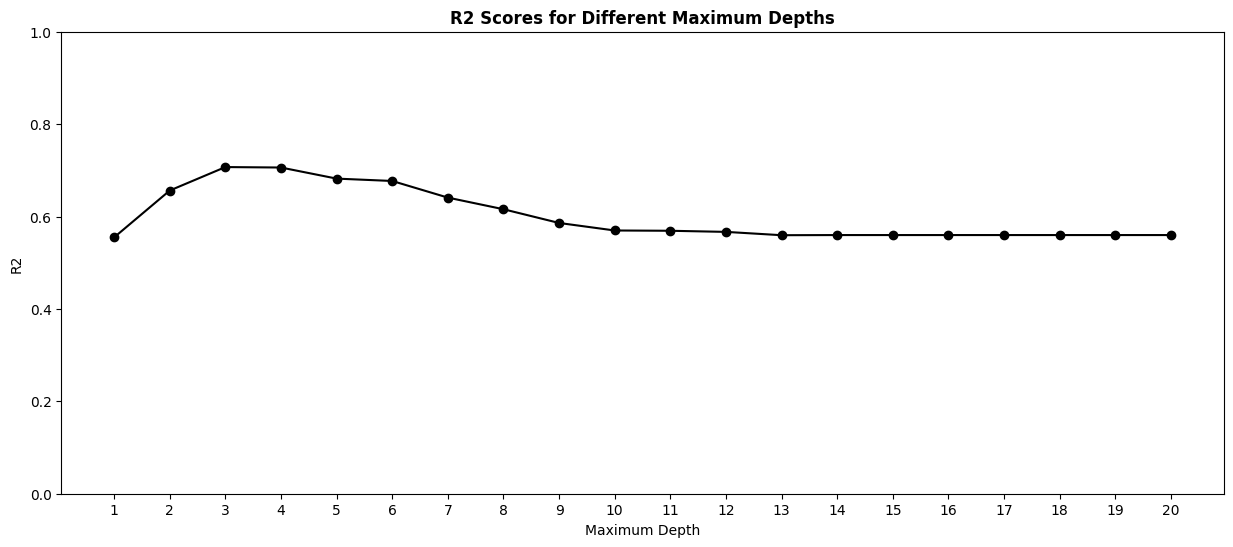

In [46]:
# Plotting the change in R2 across different maximum depths
plt.figure(figsize = (15, 6))
plt.plot(max_depth_values, r2_max_depth, 'black')
plt.scatter(max_depth_values, r2_max_depth, color = 'black')
plt.title("R2 Scores for Different Maximum Depths", fontweight = 'bold')
plt.xlabel("Maximum Depth")
plt.ylabel("R2")
plt.ylim(0.0, 1)
plt.xticks(range(1, 21))
plt.show()

**TODO: interpretation!!**

In [47]:
# Arrays for minimum samples to split
min_samples_values = np.arange(1, 11)
r2_min_samples = np.full(len(min_samples_values), np.nan)

# Fitting and scoring the model for each maximum depth
for i in range(len(min_samples_values)):
    tree = regression_tree(max_depth = int(min_samples_values[i]))
    tree.fit(train_array, train_targets)
    prediction = tree.predict(test_array)
    r2_score = r2(prediction, test_targets)
    r2_min_samples[i] = r2_score

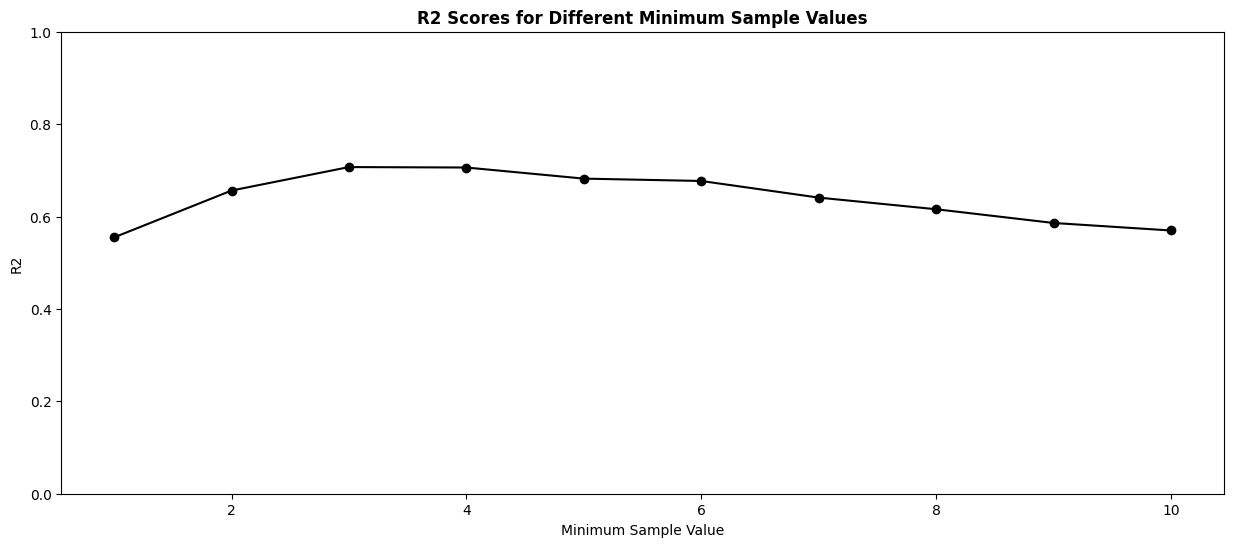

In [48]:
# Plotting the change in R2 across different maximum depths
plt.figure(figsize = (15, 6))
plt.plot(min_samples_values, r2_min_samples, 'black')
plt.scatter(min_samples_values, r2_min_samples, color = 'black')
plt.title("R2 Scores for Different Minimum Sample Values", fontweight = 'bold')
plt.xlabel("Minimum Sample Value")
plt.ylabel("R2")
plt.ylim(0.0, 1)
plt.show()

**TODO: interpretation!!**

### Regression Tree Implementation (Multiple Features)

**this section implements a regression tree in the same way using multiple features to see if it improves model accuracy/works**. As before, we begin by standardizing all features and splitting the data into training and test sets, then **initializing/fitting a model**

In [49]:
# Standardizing the features and target variable
penguin_feature_data_normal_mult = z_score_standardize(penguin_feature_data)
print(f"Standardized feature data (first five rows): \n {penguin_feature_data_normal_mult[0:5, :]}")

Standardized feature data (first five rows): 
 [[-0.88449874  0.78544923 -1.41834665]
 [-0.81112573  0.1261879  -1.06225022]
 [-0.66437972  0.43046236 -0.42127665]
 [-1.32473679  1.08972369 -0.56371522]
 [-0.84781224  1.74898502 -0.77737308]]


In [50]:
# Splitting the data into training and testing arrays
train_array_mult, test_array_mult, train_targets_mult, test_targets_mult = train_test(penguin_feature_data_normal_mult, body_mass)

# Verifying sizes of each array
print(f"Shape of training array: {train_array_mult.shape}")
print(f"Shape of training targets: {train_targets_mult.shape}")
print(f"Shape of testing array: {test_array_mult.shape}")
print(f"Shape of testing targets: {test_targets_mult.shape}")

Shape of training array: (239, 3)
Shape of training targets: (239,)
Shape of testing array: (103, 3)
Shape of testing targets: (103,)


In [53]:
# Fitting the model
tree_mult = regression_tree()
tree_mult.fit(train_array_mult, train_targets_mult)

# Predicting body mass based on testing data
prediction_mult = tree_mult.predict(test_array_mult)

**We then evaluate across various performance metrics, and print the tree**. **TODO: FINISH!**

In [54]:
# Evaluating the model
print_model_metrics(prediction_mult, test_targets_mult, n_features = 2)

Model Metrics 
------------- 
MAE: 374.76 
MSE: 215873.79 
RMSE: 464.62 
R2: 0.64 
Adjusted R2: 0.63


In [56]:
# Printing the decision tree
tree_mult.print_tree()

Feature 2 <= 0.1128679905949165
	Feature 1 <= 0.8615178423237948
		Feature 1 <= -0.0005931276022896059
			Feature 1 <= -0.2541551775805498
				Feature 0 <= 0.5371032928702542
					Feature 0 <= 0.3811856503324245
						Feature 2 <= -0.7417634363451957
							Feature 2 <= -1.2046887926044232
								Feature 0 <= -1.6732585807542761
									Predict: 2900.0
									Predict: 2850.0
								Feature 0 <= -0.3433728061669029
									Feature 0 <= -1.0129015064764084
										Predict: 3050.0
										Predict: 3200.0
									Predict: 2900.0
							Feature 0 <= -0.6552080912425626
								Predict: 3350.0
								Predict: 3250.0
						Predict: 3650.0
					Predict: 2700.0
				Feature 0 <= -0.7469243515589332
					Feature 0 <= -1.4164530518684388
						Feature 0 <= -1.4806544340898977
							Feature 1 <= -0.10201794759359423
								Predict: 3150.0
								Feature 0 <= -1.664086954722639
									Predict: 3400.0
									Predict: 3350.0
							Predict: 3700.0
						Feature 2 <= -0.9910309358693

**TODO: COMPARISON**

### Comparison with Existing Models

**This section compares this regression tree, which was built in the supervised learning package**, with the **established models using SciKit Learn**. **more information**

In [57]:
from sklearn.tree import DecisionTreeRegressor
tree_sk = DecisionTreeRegressor(max_depth = None, min_samples_split = 2)
tree_sk.fit(train_array_mult, train_targets_mult)
prediction_sk = tree_sk.predict(test_array_mult)

In [58]:
print_model_metrics(prediction_sk, test_targets_mult)

Model Metrics 
------------- 
MAE: 371.84 
MSE: 211796.12 
RMSE: 460.21 
R2: 0.65 
Adjusted R2: 0.64


The regression tree from SciKit Learn **has essentially the same accuracy/other scores** as the **built model, showing that it is verified/reliable alongside existing metrics**. **TODO - finish this!!!** **Although neither are particularly good predictors of body mass scores, their equivalent performance** validates the use of the **newly constructed regression tree/class**.